<a href="https://colab.research.google.com/github/NicoG2023/Data_Science_Final_Project/blob/Predata/src/data-science-project/data_science_project/notebooks/EDA_Rain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA "Grupo Bimbo Inventory Demand"

### Introduction

Grupo Bimbo, a leading multinational bakery company, faces a unique challenge in managing the inventory of its products. With a typical shelf life of just one week, the accuracy of daily inventory calculations is paramount. Currently, these calculations are performed by direct delivery sales employees who rely on their personal experiences to predict the forces of supply, demand, and consumer behavior at each store. The margin for error in this process is minimal. Underestimating demand results in empty shelves and lost sales, while overestimating demand leads to excess product returns and increased expenses.

Grupo Bimbo aims to create a predictive model that can accurately forecast inventory needs based on historical data, thereby optimizing the supply chain and improving efficiency.


## Libraries

In [ ]:
# importing the basic libraries
#!pip install ydata_profiling
# !pip install catboost
# !pip install lightgbm
# !pip install xgboost
# !pip install plotly
# !pip install path
from ydata_profiling import ProfileReport
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBRegressor
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# import path
# import plotly.express as px
import gc

## Charge data

In [ ]:

train_df = pd.read_csv("../Data/train/train.csv",nrows=1000000)
client_df = pd.read_csv("../Data/cliente_tabla.csv")
products_df = pd.read_csv("../Data/producto_tabla.csv")
test_df = pd.read_csv("../Data/test/test.csv")
town_state_df = pd.read_csv("../Data/town_state.csv")

In [ ]:
# Inspect the data, with funcion

def inspect_columns(df:pd.DataFrame, df_name:str)->None:
    """
    A helper function that does a deep analisis about the columns in a dataframe
    Inputs:
     df(pd.Dataframe): the dataframe that will be inspected
     df_name(str): the tittle that will be put in the output(print) of the function
    Returns:
     None
    """

    total_rows = len(df)
    result = pd.DataFrame({
        'total_rows': [total_rows] * df.shape[1],
        'rows_with_missing_values': df.isnull().sum(),
        'unique': df.nunique() == total_rows,
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'null_pct': round((df.isnull().sum() / total_rows) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=total_rows)],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes,
    })

    # Print the name of the dataframe
    print(f"\n{'='*10} {df_name} {'='*10}\n")

    # Print the head of the dataframe
    print("First few rows of the dataframe:\n")
    display(df.head())

    # Print the resulting statistics
    print("Detailed statistics:\n")
    display(result)

## Understand the data

We performed a preliminary exploration to understand the structure of the data.

In [ ]:
inspect_columns(train_df,"Training Dataframe")
inspect_columns(client_df,"Client Dataframe")
inspect_columns(products_df,"Products Dataframe")
inspect_columns(test_df,"Test Dataframe")
inspect_columns(town_state_df,"Town and State Dataframe")

### Exploratory data analysis


In [ ]:
# transform by merge with the data

train_df = train_df.merge(client_df,on = "Cliente_ID",how="left")
train_df = train_df.merge(products_df,on = "Producto_ID",how="left")
train_df = train_df.merge(town_state_df,on = "Agencia_ID",how="left")

train_df.head()

In [ ]:
# translate the language used for the data

train_df = train_df.rename({'Semana':'Week', 'Agencia_ID':'Sales_Depot_ID', 'Canal_ID':'Sales_Channel_ID', 'Ruta_SAK':'Route_ID', 'Cliente_ID':'Client_ID',
       'Producto_ID':'Product_ID', 'Venta_uni_hoy':'Sales_unit_this_week', 'Venta_hoy':'Sales_this_week', 'Dev_uni_proxima':'Returns_unit_next_week',
       'Dev_proxima':'Returns_next_week', 'Demanda_uni_equil':'Adjusted_Demand', 'NombreCliente':'Client_name', 'NombreProducto':'Product_Name',
       'Town':'Town', 'State':'State'},axis=1)

train_df.head()

In [ ]:
train_df['Week'] = train_df['Week'].astype('int8')
train_df['Sales_Depot_ID'] = train_df['Sales_Depot_ID'].astype('int16')
train_df['Sales_Channel_ID'] = train_df['Sales_Channel_ID'].astype('int8')
train_df['Route_ID'] = train_df['Route_ID'].astype('int16')
train_df['Client_ID'] = train_df['Client_ID'].astype('int32')
train_df['Product_ID'] = train_df['Product_ID'].astype('int32')
train_df['Sales_unit_this_week'] = train_df['Sales_unit_this_week'].astype('int16')
train_df['Returns_unit_next_week'] = train_df['Returns_unit_next_week'].astype('int32')
train_df['Adjusted_Demand'] = train_df['Adjusted_Demand'].astype('int32')

print(train_df.info())

# Web Scraping

According to the dataset, the data was taken in a timespan of 9 weeks. It's been decided to get the biweekly inflation and the consumer confidence index from Mexico. The info was taken from March 31st, 2016, until June 1st, 2016.

In [ ]:
#Getting biweekly inflation
import sys
import requests
from datetime import datetime

api_key = '74bcad49-835f-fab1-c9f0-fdab92570186'

api_url = f'https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/628229/es/0700/false/BIE/2.0/{api_key}?type=json'

response = requests.get(api_url)
if response.status_code == 200:
    inflation_data = response.json()
else:
    print('ERROR FAILED TO RETRIEVE DATA')
    sys.exit()

observations = inflation_data['Series'][0]['OBSERVATIONS']
dates = []
values = []
for obs in observations:
    dates.append(obs['TIME_PERIOD'])
    values.append(obs['OBS_VALUE'])

inflation_df = pd.DataFrame({
    'Fecha': dates,
    'Inflacion': values
})

inflation_df['Fecha'] = pd.to_datetime(inflation_df['Fecha'], format='%Y/%m/%d')
start_date = datetime(2016, 3, 31)
end_date = datetime(2016, 6, 1)

filtered_inflation_df = inflation_df[(inflation_df['Fecha'] >= start_date) & (inflation_df['Fecha'] <= end_date)]
filtered_inflation_df = filtered_inflation_df.reset_index(drop=True)
filtered_inflation_df

In [ ]:
#Getting consumer confidence index
api_key = '74bcad49-835f-fab1-c9f0-fdab92570186'
api_url = f'https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/454168/es/0700/false/BIE/2.0/{api_key}?type=json'

response = requests.get(api_url)
if response.status_code == 200:
    confidence_data = response.json()
else:
    print('ERROR FAILED TO RETRIEVE DATA')
    sys.exit()

observations = confidence_data['Series'][0]['OBSERVATIONS']
dates = []
values = []

for obs in observations:
    dates.append(obs['TIME_PERIOD'])
    values.append(obs['OBS_VALUE'])

confidence_data = pd.DataFrame({
    'Fecha': dates,
    'Consumer_confidence': values
})

confidence_data['Fecha'] = pd.to_datetime(confidence_data['Fecha'], format='%Y/%m')
start_date = datetime(2016, 3, 31)
end_date = datetime(2016, 6, 1)

filtered_confidence_df = confidence_data[(confidence_data['Fecha'] >= start_date) & (confidence_data['Fecha'] <= end_date)]
filtered_confidence_df = filtered_confidence_df.reset_index(drop=True)
filtered_confidence_df

## Data Merging
Having charged and understood the data now we proceed to merge it in order to create a consise and rich dataset for the model to be given 

In [ ]:
# merging train_df, filtered_confidence_df, filtered_inflation_df
weeks_to_inflation_dates = {
    'Week': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'Fecha': [
        '2016-04-01','2016-04-01',
        '2016-04-02','2016-04-02',
        '2016-05-01','2016-05-01',
        '2016-05-02','2016-05-02',
        '2016-06-01'
    ]
}
inflation_weeks_df = pd.DataFrame(weeks_to_inflation_dates)
inflation_weeks_df['Fecha'] = pd.to_datetime(inflation_weeks_df['Fecha'])

weeks_to_confidence_dates = {
    'Week': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'Fecha': [
        '2016-04-01', '2016-05-01', '2016-05-01', '2016-05-01', '2016-05-01',
        '2016-06-01', '2016-06-01', '2016-06-01', '2016-06-01'
    ]
}
confidence_weeks_df = pd.DataFrame(weeks_to_confidence_dates)
confidence_weeks_df['Fecha'] = pd.to_datetime(confidence_weeks_df['Fecha'])
print(inflation_weeks_df)
print(confidence_weeks_df)


In [ ]:
confidence_merged_df = pd.merge(confidence_weeks_df, filtered_confidence_df, on='Fecha', how='left')
inflation_merged_df = pd.merge(inflation_weeks_df, filtered_inflation_df, on='Fecha', how='left')
print(confidence_merged_df)
print(inflation_merged_df)

In [ ]:
confidence_merged_df = confidence_merged_df.drop(columns=['Fecha'])
inflation_merged_df = inflation_merged_df.drop(columns=['Fecha'])
print(confidence_merged_df)
print(inflation_merged_df)

In [ ]:
final_df = pd.merge(train_df, confidence_merged_df, on='Week', how='left')
final_df = pd.merge(final_df, inflation_merged_df, on='Week', how='left')
print(final_df.info())

In [ ]:
final_df.head()

In [ ]:
reduced_df = final_df.groupby('Week').apply(lambda x: x.sample(frac=0.2, random_state=42)).reset_index(drop=True)
del final_df
del inflation_df
gc.collect()
print(reduced_df.info())

In [ ]:
def prepare_data(df : pd.DataFrame) -> pd.DataFrame:
    if 'Week' in df.columns:
        df['Week'] = pd.to_datetime('2016-03-31') + pd.to_timedelta(df['Week'].astype(int) * 7, unit='D')
    print(df.info())
    return df
reduced_df = prepare_data(reduced_df)

In [ ]:
def last_week_feature_creation_demand(df):
    df = df.sort_values(by=['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID', 'Product_ID', 'Week'])
    df['Last_Week_Demand_1'] = df.groupby(['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID', 'Product_ID'])['Adjusted_Demand'].shift(1)
    df['Last_Week_Demand_2'] = df.groupby(['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID', 'Product_ID'])['Adjusted_Demand'].shift(2)
    df['Last_Week_Demand_3'] = df.groupby(['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID', 'Product_ID'])['Adjusted_Demand'].shift(3)
    df['Last_Week_Demand_1'] = df['Last_Week_Demand_1'].astype('float32')
    df['Last_Week_Demand_2'] = df['Last_Week_Demand_2'].astype('float32')
    df['Last_Week_Demand_3'] = df['Last_Week_Demand_3'].astype('float32')
    df['Sales_this_week'] = df['Sales_this_week'].astype('float32')
    df['Returns_next_week'] = df['Returns_next_week'].astype('float32')
    gc.collect() 
    print(df.info())
    return df

reduced_df = last_week_feature_creation_demand(reduced_df)

In [ ]:
def last_week_feature_creation_return(df : pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values(by=['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID', 'Product_ID', 'Week'])
    df['Last_Week_Return_1'] = df.groupby(['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID', 'Product_ID'])['Returns_unit_next_week'].shift(1)
    df['Last_Week_Return_2'] = df.groupby(['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID', 'Product_ID'])['Returns_unit_next_week'].shift(2)
    df['Last_Week_Return_3'] = df.groupby(['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID', 'Product_ID'])['Returns_unit_next_week'].shift(3)
    df['Last_Week_Return_1'] = df['Last_Week_Return_1'].astype('float32')
    df['Last_Week_Return_2'] = df['Last_Week_Return_2'].astype('float32')
    df['Last_Week_Return_3'] = df['Last_Week_Return_3'].astype('float32')
    gc.collect()
    print(df.info())
    return df

reduced_df = last_week_feature_creation_return(reduced_df)

# Feature Engineering

In [ ]:
#Sales Growth
def sales_growth(df:pd.DataFrame)-> pd.DataFrame:
    df['Sales_Growth_Rate_1'] = (df['Last_Week_Demand_1'] - df['Last_Week_Demand_2']) / df['Last_Week_Demand_1']
    df['Sales_Growth_Rate_2'] = (df['Last_Week_Demand_2'] - df['Last_Week_Demand_3']) / df['Last_Week_Demand_2']
    df['Sales_Growth_Rate_1'] = df['Sales_Growth_Rate_1'].astype('float32')
    df['Sales_Growth_Rate_2'] = df['Sales_Growth_Rate_2'].astype('float32')
    print(df.info())
    return df

reduced_df = sales_growth(reduced_df)


In [ ]:
# Client Total Sales
def client_total_sales(df:pd.DataFrame) -> pd.DataFrame:
    client_sales = df.groupby(['Client_ID', 'Week'])['Last_Week_Demand_1'].sum().reset_index().rename(columns={'Last_Week_Demand_1':'Total_Sales_per_Client'}).copy()
    df = df.merge(client_sales, on=['Client_ID', 'Week'], how='left')
    print(df.info())
    return df

reduced_df = client_total_sales(reduced_df)

In [ ]:
def cleaning(df:pd.DataFrame) -> pd.DataFrame:
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(0)
    df.set_index('Week', inplace=True)
    columns_to_drop = ['index', 'Sales_unit_this_week', 'Sales_this_week', 'Returns_unit_next_week', 'Returns_next_week']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    gc.collect()
    print(df.info())
    return df
reduced_df = cleaning(reduced_df)
    

# Feature Selection

In [ ]:
numeric_columns = ['Client_ID','Adjusted_Demand', 'Last_Week_Demand_1', 'Last_Week_Demand_2','Last_Week_Demand_3','Last_Week_Return_1','Last_Week_Return_2','Last_Week_Return_3',
                   'Sales_Growth_Rate_1','Sales_Growth_Rate_2', 'Total_Sales_per_Client', 'Inflacion','Consumer_confidence']
corr_matrix = reduced_df[numeric_columns].corr()
#heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix with Heatmap')
plt.show()

del corr_matrix
del numeric_columns
gc.collect()

In [32]:
def feature_selection(df:pd.DataFrame) -> pd.DataFrame:
    selected_features = ['Last_Week_Demand_1','Last_Week_Demand_2','Last_Week_Demand_3','Sales_Growth_Rate_1','Sales_Growth_Rate_2','Last_Week_Return_1',
                         'Last_Week_Return_2','Last_Week_Return_3','Total_Sales_per_Client','Client_ID','Route_ID','Sales_Channel_ID','Sales_Depot_ID',
                         'Consumer_confidence','Adjusted_Demand']
    df = df[selected_features]
    print(df.info())
    del selected_features
    gc.collect()
    return df
reduced_df = feature_selection(reduced_df)
print(reduced_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 201023 entries, 2016-04-21 to 2016-04-21
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Last_Week_Demand_1      201023 non-null  float32
 1   Last_Week_Demand_2      201023 non-null  float32
 2   Last_Week_Demand_3      201023 non-null  float32
 3   Sales_Growth_Rate_1     201023 non-null  float32
 4   Sales_Growth_Rate_2     201023 non-null  float32
 5   Last_Week_Return_1      201023 non-null  float32
 6   Last_Week_Return_2      201023 non-null  float32
 7   Last_Week_Return_3      201023 non-null  float32
 8   Total_Sales_per_Client  201023 non-null  float32
 9   Client_ID               201023 non-null  int32  
 10  Route_ID                201023 non-null  int16  
 11  Sales_Channel_ID        201023 non-null  int8   
 12  Sales_Depot_ID          201023 non-null  int16  
 13  Consumer_confidence     201023 non-null  object 
 14  Adju

## Model Selection

In [ ]:
#Train test split
X = reduced_df.drop(columns='Adjusted_Demand', axis=1)
Y = reduced_df['Adjusted_Demand']

n_weeks = reduced_df.index.nunique()
train_weeks = int(n_weeks * (8/9))

train_index = sorted(reduced_df.index.unique())[:train_weeks]
test_index = sorted(reduced_df.index.unique())[train_weeks:]

X_train = X.loc[train_index]
y_train = Y.loc[train_index]
X_test = X.loc[test_index]
y_test = Y.loc[test_index]
del X, Y
gc.collect()

In [ ]:
cl_rf = RandomForestRegressor()
cl_rf.fit(X_train, y_train)

Y_hat_rf = cl_rf.predict(X_test)
accuracy = accuracy_score(y_test, Y_hat_rf)
print("Accuracy:", accuracy)

In [ ]:
del X
del Y
del X_train
del X_test
del X_test_scaled
del X_train_scaled
del y_hat
del y_test
del y_train
del mse
del lr
gc.collect()

## Business Questions


1. What are our best and worst customers?

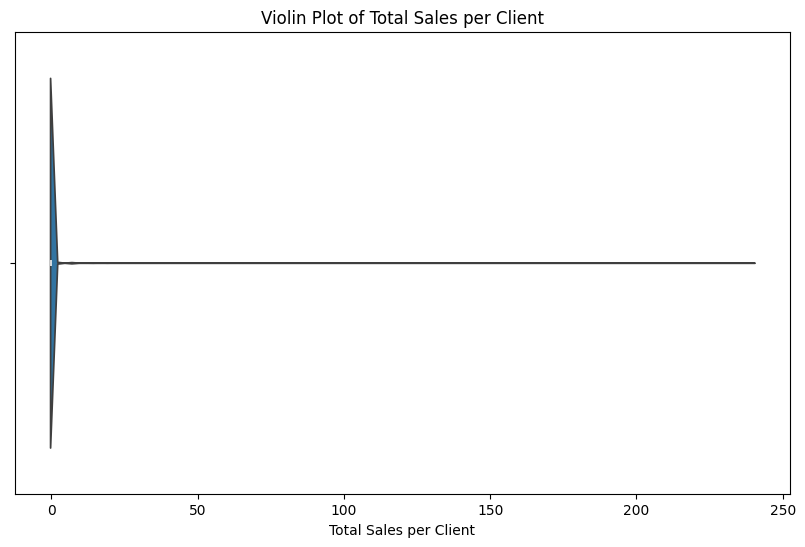

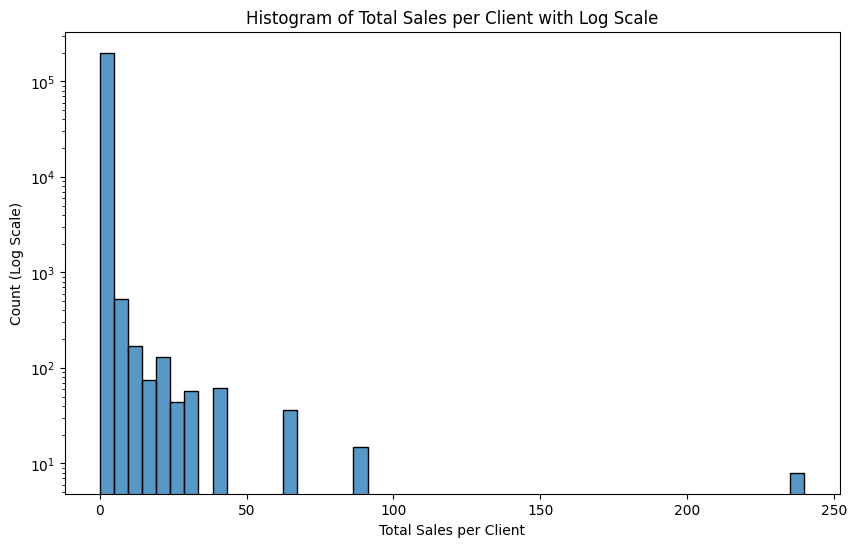

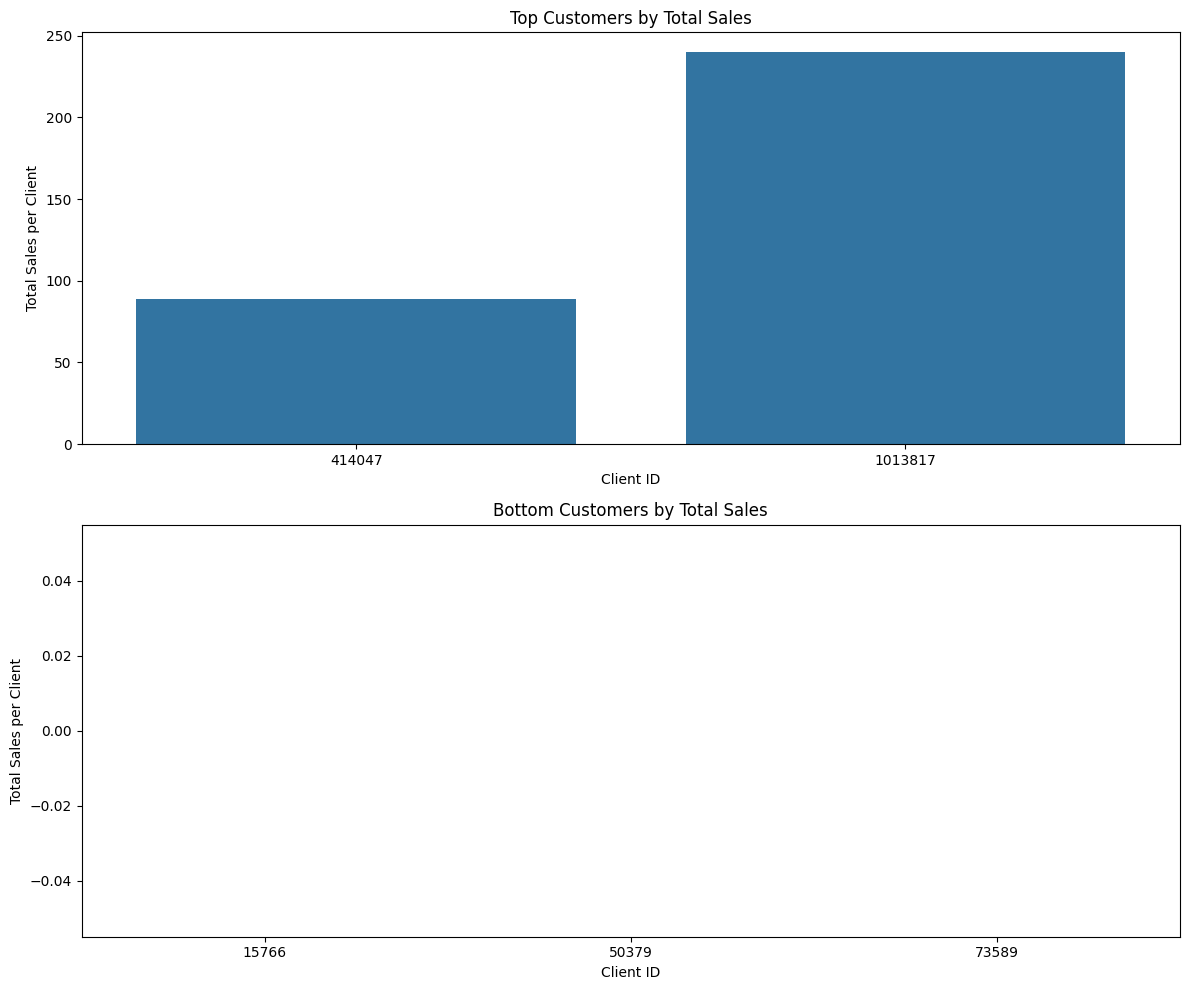

In [48]:
# Summary Statistics
summary_stats = reduced_df['Total_Sales_per_Client'].describe()
top_10_percent = reduced_df['Total_Sales_per_Client'].quantile(0.9)
bottom_10_percent = reduced_df['Total_Sales_per_Client'].quantile(0.1)

# Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x=reduced_df['Total_Sales_per_Client'])
plt.title('Violin Plot of Total Sales per Client')
plt.xlabel('Total Sales per Client')
plt.show()

# Histogram with Log Scale
plt.figure(figsize=(10, 6))
sns.histplot(reduced_df['Total_Sales_per_Client'], bins=50)
plt.yscale('log')
plt.title('Histogram of Total Sales per Client with Log Scale')
plt.xlabel('Total Sales per Client')
plt.ylabel('Count (Log Scale)')
plt.show()

# Top and Bottom Customers
top_10_customers = reduced_df.nlargest(10, 'Total_Sales_per_Client')
bottom_10_customers = reduced_df.nsmallest(10, 'Total_Sales_per_Client')

fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Top Customers
sns.barplot(data=top_10_customers, x='Client_ID', y='Total_Sales_per_Client', ax=ax[0])
ax[0].set_title('Top Customers by Total Sales')
ax[0].set_xlabel('Client ID')
ax[0].set_ylabel('Total Sales per Client')

# Bottom 10 Customers
sns.barplot(data=bottom_10_customers, x='Client_ID', y='Total_Sales_per_Client', ax=ax[1])
ax[1].set_title('Bottom Customers by Total Sales')
ax[1].set_xlabel('Client ID')
ax[1].set_ylabel('Total Sales per Client')

plt.tight_layout()
plt.show()



2. What is the relationship between sales growth rates (1 and 2) and adjusted demand?

/home/giovanny/.pyenv/versions/data-science/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/giovanny/.pyenv/versions/data-science/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Correlation between Consumer Confidence and Adjusted Demand: nan


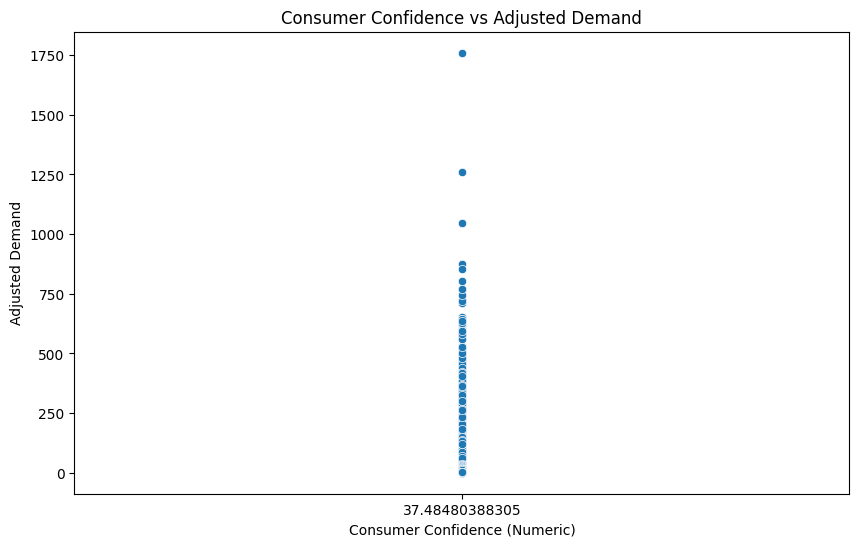

In [49]:
# Example: If consumer confidence is categorical like 'High', 'Medium', 'Low'
reduced_df['Consumer_confidence_numeric'] = reduced_df['Consumer_confidence'].astype('category').cat.codes

# Calculate correlation
correlation = reduced_df['Consumer_confidence_numeric'].corr(reduced_df['Adjusted_Demand'])
print(f"Correlation between Consumer Confidence and Adjusted Demand: {correlation:.2f}")

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_df['Consumer_confidence_numeric'], y=reduced_df['Adjusted_Demand'])
plt.title('Consumer Confidence vs Adjusted Demand')
plt.xlabel('Consumer Confidence (Numeric)')
plt.ylabel('Adjusted Demand')
plt.xticks(ticks=range(len(reduced_df['Consumer_confidence'].unique())), labels=reduced_df['Consumer_confidence'].unique())
plt.show()


3. How are our sales going against the returns, and our adjusted demand?

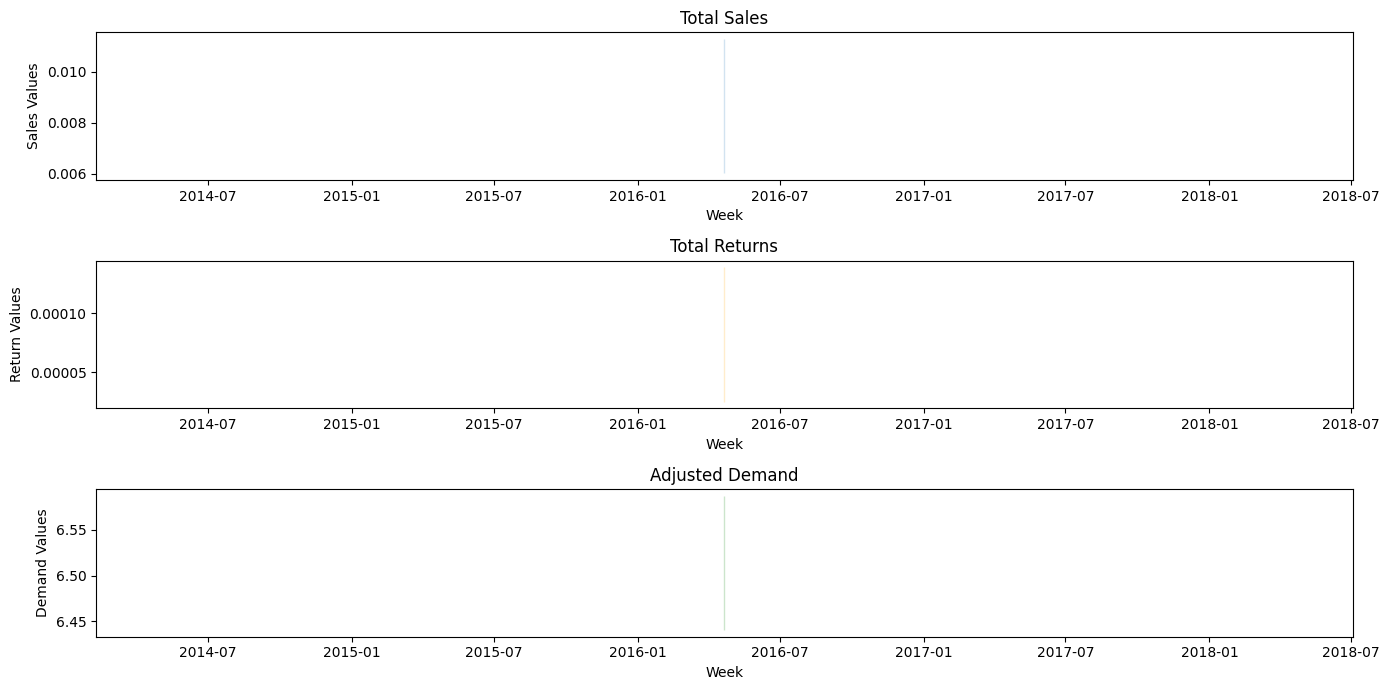

In [50]:

# Calculate total sales and total returns separately
total_sales = reduced_df[['Last_Week_Demand_1', 'Last_Week_Demand_2', 'Last_Week_Demand_3']].sum(axis=1)
total_returns = reduced_df[['Last_Week_Return_1', 'Last_Week_Return_2', 'Last_Week_Return_3']].sum(axis=1)
adjusted_demand = reduced_df['Adjusted_Demand']

# Plotting
plt.figure(figsize=(14, 7))

# Total Sales
plt.subplot(3, 1, 1)
sns.lineplot(data=total_sales)
plt.title('Total Sales')
plt.ylabel('Sales Values')

# Total Returns
plt.subplot(3, 1, 2)
sns.lineplot(data=total_returns, color='orange')
plt.title('Total Returns')
plt.ylabel('Return Values')

# Adjusted Demand
plt.subplot(3, 1, 3)
sns.lineplot(data=adjusted_demand, color='green')
plt.title('Adjusted Demand')
plt.ylabel('Demand Values')

plt.tight_layout()
plt.show()



4. What are our most used routes?

/tmp/ipykernel_3920/3033400036.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_routes_df, x='Route_ID', y='Usage_Count', palette='viridis')


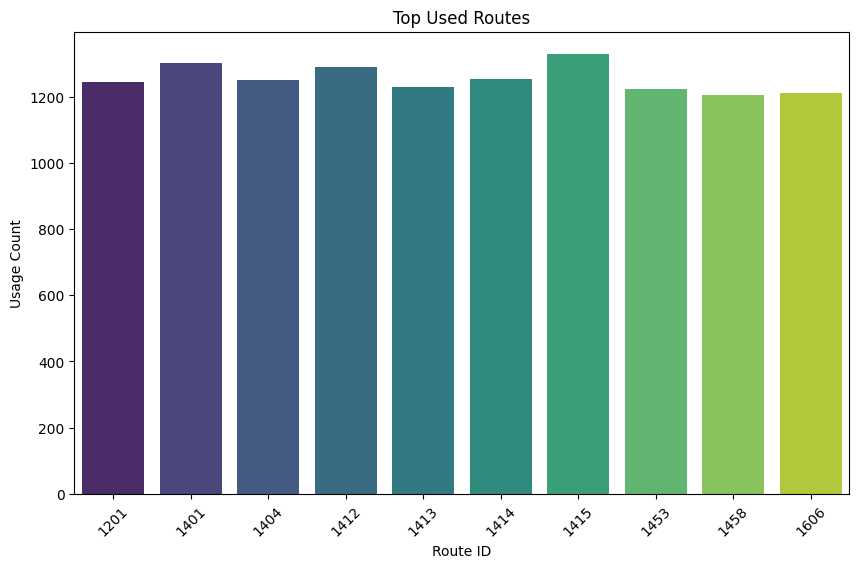

In [52]:
# Count occurrences of each route
route_counts = reduced_df['Route_ID'].value_counts()

# Convert to DataFrame for plotting
route_counts_df = route_counts.reset_index()
route_counts_df.columns = ['Route_ID', 'Usage_Count']

# Get the top most used routes
top_routes_df = route_counts_df.head(10)

# Bar Plot for Most Used Routes
plt.figure(figsize=(10, 6))
sns.barplot(data=top_routes_df, x='Route_ID', y='Usage_Count', palette='viridis')
plt.title('Top Used Routes')
plt.xlabel('Route ID')
plt.ylabel('Usage Count')
plt.xticks(rotation=45)
plt.show()